<a href="https://colab.research.google.com/github/taniasahu/Automatic-Modulation-Classification-/blob/main/Convolutional_SNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch -q
!pip install numpy -q
!pip install matplotlib -q
!pip install seaborn -q
!pip install scikit-learn -q
!pip install scipy -q
!pip install snntorch -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 5.3 MB/s eta 0:00:00


In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Path to file location in Google Drive
file_path = '/content/drive/My Drive/AMC_dataset.mat'

Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import snntorch as snn
from snntorch import surrogate
import scipy.io
import numpy as np
import seaborn as sns

# Modulation types
mod_types = ["BPSK", "QPSK", "8PSK", "16QAM", "64QAM", "GFSK", "CPFSK", "PAM4", "B-FM", "DSB-AM", "SSB-AM"]

# Load dataset
mat = scipy.io.loadmat(file_path)
data = mat['data']  # shape: (totalFrames, 1024, 2)
labels = mat['labels']  # shape: (totalFrames, 1)
split = mat['split']  # shape: (totalFrames, 1)

# Split data
train_idx = split.flatten() == 0
val_idx = split.flatten() == 1
test_idx = split.flatten() == 2

X_train = torch.tensor(data[train_idx], dtype=torch.float32)  # shape: (n_train, 1024, 2)
y_train = torch.tensor(labels[train_idx], dtype=torch.long).squeeze() - 1  # Adjust labels to 0-10
X_val = torch.tensor(data[val_idx], dtype=torch.float32)
y_val = torch.tensor(labels[val_idx], dtype=torch.long).squeeze() - 1
X_test = torch.tensor(data[test_idx], dtype=torch.float32)
y_test = torch.tensor(labels[test_idx], dtype=torch.long).squeeze() - 1

# Reshape for Conv1d: (batch, channels, length)
X_train = X_train.permute(0, 2, 1)  # (n_train, 2, 1024)
X_val = X_val.permute(0, 2, 1)
X_test = X_test.permute(0, 2, 1)

# DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define SNN with three convolutional layers
class SNN(nn.Module):
    def __init__(self, num_steps=50, beta=0.9):
        super().__init__()
        self.num_steps = num_steps
        self.conv1 = nn.Conv1d(2, 16, kernel_size=5, padding=2)
        nn.init.kaiming_normal_(self.conv1.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(self.conv1.bias, 0)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid())
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, padding=2)
        nn.init.kaiming_normal_(self.conv2.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(self.conv2.bias, 0)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid())
        self.conv3 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        nn.init.kaiming_normal_(self.conv3.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(self.conv3.bias, 0)
        self.lif3 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid())
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(64, 11)
        nn.init.normal_(self.fc.weight, mean=0.0, std=0.1)
        nn.init.normal_(self.fc.bias, mean=0.0, std=0.1)
        self.lif4 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid())

    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem4 = self.lif4.init_leaky()
        spk_rec = []
        for _ in range(self.num_steps):
            cur = self.conv1(x)
            spk1, mem1 = self.lif1(cur, mem1)
            cur = self.conv2(spk1)
            spk2, mem2 = self.lif2(cur, mem2)
            cur = self.conv3(spk2)
            spk3, mem3 = self.lif3(cur, mem3)
            cur = self.pool(spk3).view(x.size(0), -1)
            cur = self.fc(cur)
            spk4, mem4 = self.lif4(cur, mem4)
            spk_rec.append(spk4)
        return torch.stack(spk_rec, dim=0)

# Initialize model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Training loop
num_epochs = 30
train_losses, val_losses, train_accs, val_accs = [], [], [], []
for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    for data, targets in train_loader:
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()
        spk_rec = model(data)
        loss = criterion(torch.sum(spk_rec, dim=0), targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(torch.sum(spk_rec, dim=0), 1)
        train_total += targets.size(0)
        train_correct += (predicted == targets).sum().item()
    scheduler.step()
    train_losses.append(train_loss / len(train_loader))
    train_accs.append(100 * train_correct / train_total)

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for data, targets in val_loader:
            data, targets = data.to(device), targets.to(device)
            spk_rec = model(data)
            loss = criterion(torch.sum(spk_rec, dim=0), targets)
            val_loss += loss.item()
            _, predicted = torch.max(torch.sum(spk_rec, dim=0), 1)
            val_total += targets.size(0)
            val_correct += (predicted == targets).sum().item()
    val_losses.append(val_loss / len(val_loader))
    val_accs.append(100 * val_correct / val_total)
    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.2f}%, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.2f}%')

# Test model
model.eval()
test_correct, test_total = 0, 0
all_preds, all_targets = [], []
with torch.no_grad():
    for data, targets in test_loader:
        data, targets = data.to(device), targets.to(device)
        spk_rec = model(data)
        _, predicted = torch.max(torch.sum(spk_rec, dim=0), 1)
        test_total += targets.size(0)
        test_correct += (predicted == targets).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())
test_acc = 100 * test_correct / test_total
print(f'Test Accuracy: {test_acc:.2f}%')

# Save model
torch.save(model.state_dict(), 'SNN_model.pth')

Epoch 1, Train Loss: 1.0368, Train Acc: 57.00%, Val Loss: 0.5851, Val Acc: 80.23%
Epoch 2, Train Loss: 0.5380, Train Acc: 77.14%, Val Loss: 0.4721, Val Acc: 80.43%
Epoch 3, Train Loss: 0.4421, Train Acc: 81.30%, Val Loss: 0.4683, Val Acc: 81.60%
Epoch 4, Train Loss: 0.3952, Train Acc: 82.99%, Val Loss: 0.3878, Val Acc: 84.12%
Epoch 5, Train Loss: 0.3638, Train Acc: 84.43%, Val Loss: 0.4122, Val Acc: 83.60%
Epoch 6, Train Loss: 0.3497, Train Acc: 84.94%, Val Loss: 0.3585, Val Acc: 85.36%
Epoch 7, Train Loss: 0.3297, Train Acc: 85.63%, Val Loss: 0.3353, Val Acc: 83.87%
Epoch 8, Train Loss: 0.3273, Train Acc: 85.55%, Val Loss: 0.3668, Val Acc: 84.68%
Epoch 9, Train Loss: 0.3119, Train Acc: 86.18%, Val Loss: 0.3114, Val Acc: 87.08%
Epoch 10, Train Loss: 0.3086, Train Acc: 86.23%, Val Loss: 0.3279, Val Acc: 84.94%
Epoch 11, Train Loss: 0.2785, Train Acc: 87.71%, Val Loss: 0.3075, Val Acc: 86.47%
Epoch 12, Train Loss: 0.2768, Train Acc: 87.76%, Val Loss: 0.2998, Val Acc: 85.74%
Epoch 13, Tra

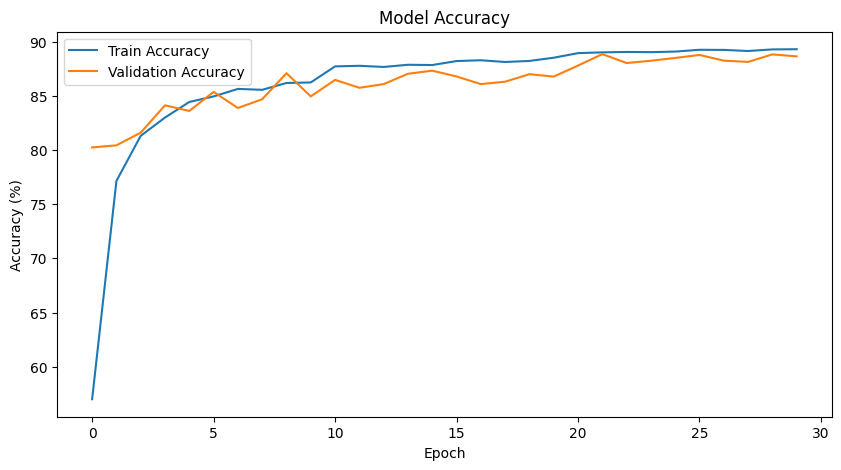

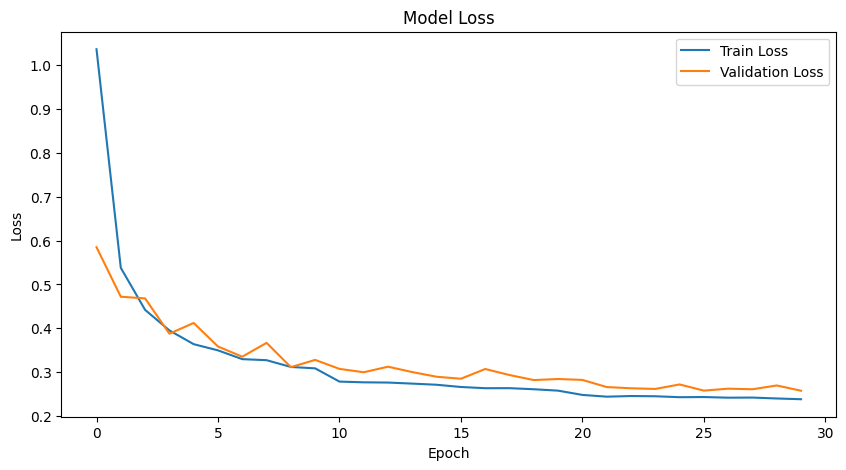

In [4]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.savefig('accuracy_plot.png')
plt.show()

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_plot.png')
plt.show()

In [5]:
from sklearn.metrics import classification_report
# Classification report
print('\nClassification Report:')
print(classification_report(all_targets, all_preds, target_names=mod_types))


Classification Report:
              precision    recall  f1-score   support

        BPSK       0.81      0.91      0.86       773
        QPSK       0.68      0.65      0.66       761
        8PSK       0.74      0.74      0.74       751
       16QAM       0.80      0.81      0.81       724
       64QAM       0.91      0.86      0.88       794
        GFSK       0.92      0.90      0.91       737
       CPFSK       0.92      0.93      0.92       741
        PAM4       1.00      1.00      1.00       733
        B-FM       1.00      0.99      1.00       747
      DSB-AM       1.00      0.99      1.00       344
      SSB-AM       0.99      1.00      1.00       553

    accuracy                           0.88      7658
   macro avg       0.89      0.89      0.89      7658
weighted avg       0.88      0.88      0.88      7658



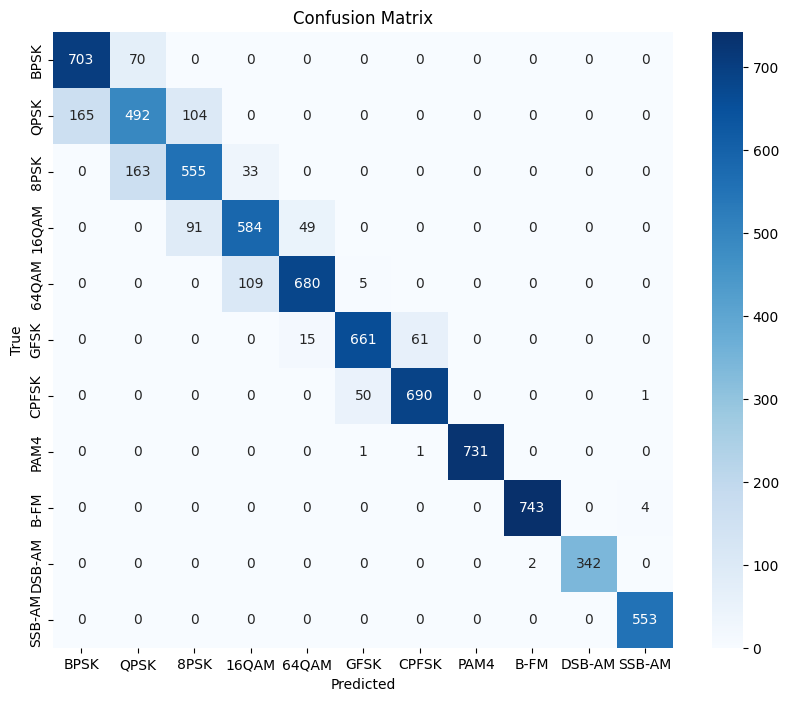

In [6]:
from sklearn.metrics import confusion_matrix
# Confusion matrix
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=mod_types, yticklabels=mod_types)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix.png')
plt.show()